# Sketch AI

## Configuration

In [40]:
# VERSION
model_version = 8
model_name    = f"v{model_version}-s2s"
model_bt_file = model_name + "-bt.pt"
model_bv_file = model_name + "-bv.pt"

In [41]:
# MODE
TUNE_HIDDEN = True
TUNE_LR     = False
TUNE_FINAL  = False

Parametros testeados para tuning:

### Division de ejecucion
- Eric: Learning Rate
- Grover: Hidden sizes

In [42]:
# TUNE HYPERPARAMETERS
hidden_size_encoder_ls = [128,256,512]
hidden_size_decoder_ls = [256,512,2048]
learning_rate_ls       = [1e-2,1e-3,1e-4]

In [43]:
# MODEL HYPERPARAMETERS
#Encoder-Decoder config
encoding_size       = 5
latent_size         = 128
hidden_size_encoder = 512
hidden_size_decoder = 2048
encoder_layers      = 1
decoder_layers      = 1
# TRAINING HYPERPARAMETERS
num_epochs    = 100
batch_size    = 64
learning_rate = 1e-3
CLASS_WEIGTHS = (1,10,100)
MOV_WEIGHT    = 1
ACT_WEIGHT    = 10 

In [44]:
# DATASET CONFIG
TRAIN_MAX_SIZE = 6400
VALID_MAX_SIZE = 320
TEST_MAX_SIZE = 320

In [45]:
# CANVAS CONFIG
WIDTH  = 512
HEIGHT = 256
#WIDTH  = 1084
#HEIGHT = 526

In [46]:
# RANDOM CONFIG
SEED = 42

In [47]:
# ENCODING CONFIG
DELTA_SIZE = 2
CLASS_SIZE = 3
MAX_SEQUENCE_LENGTH = 100
START_TOKEN         = (0,0,1,0,0)
PAD_MARKER          = -100
PAD_TOKEN           = (0,0,PAD_MARKER,PAD_MARKER,PAD_MARKER)

## Setup

### Imports

In [48]:
import numpy as np

In [49]:
%pip install -qU drawsvg

Note: you may need to restart the kernel to use updated packages.


In [50]:
import drawsvg as draw

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import random

### Runtime Config

In [52]:
# Seed
torch.manual_seed(SEED)
random.seed(SEED)

In [53]:
#device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset

### Local storage

In [54]:
dataset_dir = "dataset"
dataset_filename = "dataset.npz"

In [55]:
!mkdir $dataset_dir

Ya existe el subdirectorio o el archivo dataset.


### Download

In [56]:
dataset_url = "https://storage.googleapis.com/quickdraw_dataset/sketchrnn/airplane.npz"

In [57]:
!curl -o "$dataset_dir"/"$dataset_filename" "$dataset_url"
!echo "FILE SIZE:"
!du -h "$dataset_dir"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 11.0M    0  1926    0     0   4697      0  0:41:09 --:--:--  0:41:09  4709
  5 11.0M    5  613k    0     0   410k      0  0:00:27  0:00:01  0:00:26  410k
 12 11.0M   12 1406k    0     0   582k      0  0:00:19  0:00:02  0:00:17  582k
 18 11.0M   18 2142k    0     0   628k      0  0:00:18  0:00:03  0:00:15  628k
 24 11.0M   24 2814k    0     0   631k      0  0:00:17  0:00:04  0:00:13  631k
 31 11.0M   31 3533k    0     0   652k      0  0:00:17  0:00:05  0:00:12  705k
 37 11.0M   37 4263k    0     0   664k      0  0:00:17  0:00:06  0:00:11  741k
 45 11.0M   45 5168k    0     0   694k      0  0:00:16  0:00:07  0:00:09  747k
 52 11.0M   52 5966k    0     0   707k      0  0:00:16  0:00:08  0:00:08  761k
 59 11.0M   59 6766k    0     0   718k      0  0:00

"FILE SIZE:"


"du" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


### Load

In [58]:
dataset = np.load(dataset_dir+"/"+dataset_filename, encoding='latin1', allow_pickle=True)

In [59]:
raw_train_dataset = dataset["train"][:TRAIN_MAX_SIZE]
raw_valid_dataset = dataset["valid"][:VALID_MAX_SIZE]
raw_test_dataset = dataset["test"][:TEST_MAX_SIZE]

In [60]:
max_len = 0
for stroke3 in raw_train_dataset:
    max_len = max(max_len,stroke3.shape[0])
for stroke3 in raw_valid_dataset:
    max_len = max(max_len,stroke3.shape[0])
for stroke3 in raw_test_dataset:
    max_len = max(max_len,stroke3.shape[0])
print(max_len)

99


In [61]:
def render_sheep(stroke_3):
  d = draw.Drawing(WIDTH, HEIGHT, origin="center")
  d.append(draw.Rectangle(-WIDTH/2,-HEIGHT/2,WIDTH,HEIGHT, fill='rgb(255,255,255)'))
  x=0
  y=0
  svg_points = [0,0]
  for dx,dy,end in stroke_3:
    x+=dx
    y+=dy
    svg_points.append(x)
    svg_points.append(y)
    if end:
      lines = draw.Lines(*svg_points,fill='none', stroke='black')
      svg_points = []
      d.append(lines)
  # use d.as_svg() to extract full svg
  return d

Train size: 6400
Test size: 320
Validate size: 320
Stroke 3 input shape: n x 3
*(n max = 250)


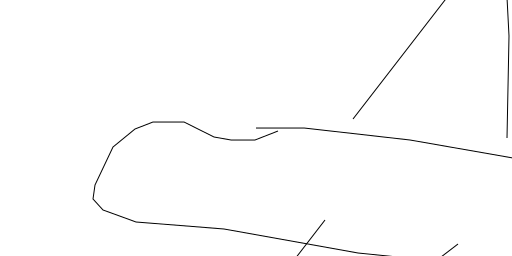

In [62]:
print("Train size:", raw_train_dataset.shape[0])
print("Test size:", raw_test_dataset.shape[0])
print("Validate size:", raw_valid_dataset.shape[0])
print("Stroke 3 input shape: n x",raw_train_dataset[0].shape[1])
print("*(n max = 250)")

d = render_sheep(raw_train_dataset[5]) #100
d

### Preprocess

In [63]:
def render_sequence(sequence):
  d = draw.Drawing(WIDTH, HEIGHT, origin="center")
  d.append(draw.Rectangle(-WIDTH/2,-HEIGHT/2,WIDTH,HEIGHT, fill='rgb(255,255,255)'))
  x=0
  y=0
  svg_points = []
  for i, (dx,dy,line,lift,end) in enumerate(sequence):
    x+=dx.item()
    y+=dy.item()
    svg_points.append(x)
    svg_points.append(y)
    if lift or end:
      lines = draw.Lines(*svg_points,fill='none', stroke='black')
      svg_points = []
      d.append(lines)
    if end:
      break
    if i == len(sequence)-1:
      # Force draw
      lines = draw.Lines(*svg_points,fill='none', stroke='black')
      svg_points = []
      d.append(lines)
  # use d.as_svg() to extract full svg
  return d

In [64]:
def preprocess_sequence(stroke_3):
  result = [START_TOKEN,]
  for i in range(len(stroke_3)):
    dx     = stroke_3[i][0]
    dy     = stroke_3[i][1]
    action = stroke_3[i][2]

    end = int(i == len(stroke_3)-1)
    lift = action if i != len(stroke_3)-1 else 0
    line = 1-action if i != len(stroke_3)-1 else 0

    fv = (dx,dy,line,lift,end)
    result.append(fv)
  # PAD ENDING
  for i in range(MAX_SEQUENCE_LENGTH-len(stroke_3)):
    fv = PAD_TOKEN
    result.append(fv)
  return np.array(result)

In [65]:
def preprocess_dataset(dataset):
  new_dataset = np.array([preprocess_sequence(elem) for elem in dataset])
  new_dataset = torch.from_numpy(new_dataset)
  new_dataset = new_dataset.float()
  return new_dataset

In [66]:
train_dataset = preprocess_dataset(raw_train_dataset)
valid_dataset = preprocess_dataset(raw_valid_dataset)
test_dataset = preprocess_dataset(raw_test_dataset)

In [67]:
#With padding
train_dataset.shape
train_dataset[0][3]

tensor([-24.,  -6.,   1.,   0.,   0.])

tensor([[   0.,    0.,    1.,    0.,    0.],
        [  48.,    0.,    1.,    0.,    0.],
        [ 106.,   12.,    1.,    0.,    0.],
        [ 143.,   25.,    1.,    0.,    0.],
        [  40.,   11.,    1.,    0.,    0.],
        [  69.,   29.,    1.,    0.,    0.],
        [  28.,   18.,    1.,    0.,    0.],
        [ -36.,   38.,    1.,    0.,    0.],
        [ -26.,   16.,    1.,    0.,    0.],
        [ -23.,    5.,    1.,    0.,    0.],
        [ -51.,   -1.,    1.,    0.,    0.],
        [ -88.,  -17.,    1.,    0.,    0.],
        [-108.,  -11.,    1.,    0.,    0.],
        [-134.,  -24.,    1.,    0.,    0.],
        [ -88.,   -7.,    1.,    0.,    0.],
        [ -33.,  -12.,    1.,    0.,    0.],
        [ -10.,  -11.,    1.,    0.,    0.],
        [   2.,  -14.,    1.,    0.,    0.],
        [  18.,  -38.,    1.,    0.,    0.],
        [  22.,  -18.,    1.,    0.,    0.],
        [  18.,   -7.,    1.,    0.,    0.],
        [  31.,    0.,    1.,    0.,    0.],
        [ 

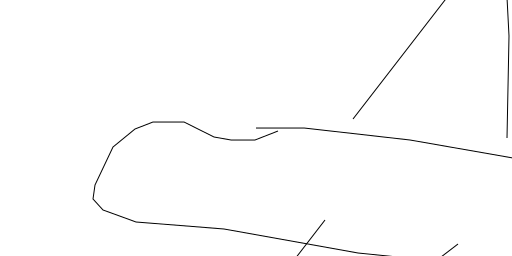

In [68]:
#s = preprocess_sequence(raw_train_dataset[100])
s = train_dataset[5]
s=s.to(device)
print(s)
render_sequence(s)

## Model

Referencias:
https://github.com/bentrevett/pytorch-seq2seq/blob/rewrite/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

In [69]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size_in, rnn_layers, latent_size, dropout=0.1):
    super(Encoder,self).__init__()
    # Input config
    self.input_size  = input_size
    # RNN config
    self.hidden_size_in  = hidden_size_in
    self.latent_size = latent_size
    self.rnn_layers  = rnn_layers
    # Layers
    self.rnn = nn.LSTM(self.input_size,
                       self.hidden_size_in,
                       self.rnn_layers,
                       bidirectional=True)
    self.fc_latent = nn.Linear(2*2*self.rnn_layers*self.hidden_size_in,
                      self.latent_size)
    self.dropout = nn.Dropout(dropout)
  def forward(self, x):
    # x shape: (seq_length, batch, input_size)
    num_batch = x.shape[1]
    # RNN
    # output shape: (seq_length, batch, D * hidden_size)
    # hidden shape: (D * num_layers, batch, hidden_size)
    # cell   shape: (D * num_layers, batch, hidden_size)
    # * Note: D=2 if bidiretional=True else 1
    outputs, (h, c) = self.rnn(x)
    # hc   shape: (D * num_layers, batch, 2*hidden_size)
    hc = torch.cat( (h,c), 2 )
    hc = torch.movedim(hc,0,2)
    # hc   shape: (batch, 2*D*num_layers*hidden_size)
    hc = hc.reshape(num_batch,-1)
    # context  shape: (batch, latent_size)
    context =  self.fc_latent(self.dropout(hc))

    ### RETURN CONTEXT VECTOR
    return context.contiguous()

In [70]:
class Decoder(nn.Module):
  def __init__(self, input_size, output_size_delta, output_size_class, hidden_size, rnn_layers, latent_size, dropout=0.1):
    super(Decoder,self).__init__()
    # Input-Output config
    self.input_size        = input_size
    self.latent_size       = latent_size
    self.output_size_delta = output_size_delta
    self.output_size_class = output_size_class
    # RNN config
    self.hidden_size = hidden_size
    self.rnn_layers  = rnn_layers
    # Layers
    self.fc_hidden = nn.Linear(self.latent_size,
                      self.hidden_size*self.rnn_layers)
    self.fc_cell   = nn.Linear(self.latent_size,
                      self.hidden_size*self.rnn_layers)
    self.rnn = nn.LSTM(self.input_size+self.latent_size,
                       self.hidden_size,
                       self.rnn_layers)
    self.fc_dlt  = nn.Linear(self.hidden_size,
                        self.output_size_delta)
    self.fc_cls  = nn.Linear(self.hidden_size,
                        self.output_size_class)
    self.dropout = nn.Dropout(dropout)
  def forward(self, x, context, hidden, cell):
    ### GET RNN INPUT
    # x shape:         (batch, input_size) but need N batches of seq_length 1
    x      = x.unsqueeze(0) #(1, batch, input_size)
    # context shape:  (batch, latent_size) but need N batches of seq_length 1
    context = context.unsqueeze(0) #(1, batch, input_size)
    # rnn_input shape: (1, batch, input_size+latent_size)
    rnn_input = torch.cat((x, context),2).contiguous()

    ### RNN
    # output shape: (1, batch, D * hidden_size)
    # hidden shape: (D * num_layers, batch, hidden_size)
    # cell   shape: (D * num_layers, batch, hidden_size)
    # * Note: D=2 if bidiretional=True else 1
    output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))

    ### GET PREDICTIONS
    # pred_delta shape: (1, batch, output_size_delta)
    # pred_class shape: (1, batch, output_size_class)
    pred_delta =  self.fc_dlt(self.dropout(output))
    pred_class =  self.fc_cls(self.dropout((output))) #torch.sigmoid(self.fc_cls(self.dropout((output))))
    # pred_delta shape: (batch, output_size_delta)
    # pred_class shape: (batch, output_size_class)
    pred_delta = pred_delta.squeeze(0)
    pred_class = pred_class.squeeze(0)

    ### RETURN PREDICTIONS AND STATE
    return pred_delta, pred_class, hidden, cell

In [71]:


class Stroke2Stroke(nn.Module):
  def __init__(self, encoding_size, delta_size, class_size, hidden_size_encoder, hidden_size_decoder, encoder_layers, decoder_layers, latent_size, device, dropout=0.1):
    super(Stroke2Stroke, self).__init__()
    assert encoding_size == delta_size+class_size
    # SIZE CONFIG
    self.encoding_size = encoding_size
    self.delta_size    = delta_size
    self.class_size    = class_size
    self.latent_size   = latent_size
    # ENCODER/DECODER
    # Encoder: (input_size, hidden_size_in, rnn_layers, latent_size, dropout=0.1)
    # Decoder: (input_size, output_size_delta, output_size_class, hidden_size, rnn_layers, latent_size, dropout=0.1):
    self.encoder = Encoder(encoding_size, hidden_size_encoder, encoder_layers, latent_size)
    self.decoder = Decoder(encoding_size, self.delta_size, self.class_size, hidden_size_decoder, decoder_layers, latent_size)
    # DEVICE
    self.device = device
    # INITIAL STATE LAYERS
    self.fc_hidden = nn.Linear(self.latent_size,
                      hidden_size_decoder*decoder_layers)
    self.fc_cell   = nn.Linear(self.latent_size,
                      hidden_size_decoder*decoder_layers)
    self.dropout = nn.Dropout(dropout)

  def get_initial_states(self, context):
    num_batch = context.shape[0]
    ### EXTRACT HIDDEN AND CELL FROM CONTEXT VECTOR
    # context shape: (batch, latent_size)
    # hidden  shape: (batch, num_layers*hidden_size)
    # cell    shape: (batch, num_layers*hidden_size)
    hidden =  self.fc_hidden(self.dropout(context))
    cell   =  self.fc_cell(self.dropout(context))
    # hidden  shape: (num_layers, batch, hidden_size)
    # cell    shape: (num_layers, batch, hidden_size)
    hidden = hidden.reshape(num_batch,self.decoder.rnn_layers,self.decoder.hidden_size)
    cell   = cell.reshape(num_batch,self.decoder.rnn_layers,self.decoder.hidden_size)
    hidden = torch.movedim(hidden,0,1).contiguous()
    cell   = torch.movedim(cell,0,1).contiguous()
    ### RETURN INITIAL STATES
    return hidden, cell

  def forward(self, source, target, teacher_force_ratio=0.5):
    ### GET SHAPES
    # source shape: (src_seq_length, batch, encoding_size)
    # target shape: (trg_seq_length, batch, encoding_size)
    batch_size  = source.shape[1]
    target_len  = target.shape[0]
    output_size = target.shape[2]

    ### RESREVE DELTA AND CLASS PREDICTION TENSORS
    # predictions_dlt shape: (src_seq_length, batch, output_size_delta)
    # predictions_cls shape: (src_seq_length, batch, output_size_class)
    predictions_dlt = torch.zeros(target_len, batch_size, self.delta_size).to(device)
    predictions_cls = torch.zeros(target_len, batch_size, self.class_size).to(device)

    ### GET CONTEXT FROM ENCODER
    # hidden shape: (D * num_layers, batch, hidden_size)
    # cell   shape: (D * num_layers, batch, hidden_size)
    context = self.encoder(source)

    ### GET INITIAL STATES
    hidden, cell = self.get_initial_states(context)

    ### START TOKEN
    x = target[0]
    ### GENERATE
    for t in range(1, target_len):
      # pred_delta shape: (batch, output_size_delta)
      # pred_class shape: (batch, output_size_class)
      pred_delta, pred_class, hidden, cell = self.decoder(x, context, hidden, cell)
      predictions_dlt[t] = pred_delta
      predictions_cls[t] = pred_class

      # Get max from one hot encoded actions
      #action = pred_class.argmax(1)
      #best_action_guess = F.one_hot(action, num_classes=self.class_size).float()

      # Create best_guess
      # best_guess shape: (batch, encoding_size)
      #best_guess = torch.cat((pred_delta, best_action_guess),1)
      best_guess = torch.cat((pred_delta, pred_class),1)

      # Select next input
      x = target[t] if random.random() < teacher_force_ratio else best_guess

    return predictions_dlt, predictions_cls

## Utils

In [72]:
# Parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [73]:
# DATA LOADERS
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

## Display

## Test

In [74]:
# DATA LOADERS
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [75]:
c_weights = torch.tensor(CLASS_WEIGTHS)
mse_fn = nn.MSELoss(reduction="none")
cross_entropy_fn =  nn.CrossEntropyLoss(ignore_index=PAD_MARKER)#, weight=c_weights)

def test_fn(model, data_loader):
    model.eval()
    test_loss = 0
    test_mov_loss = 0
    test_act_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch.to(device)
            trg = batch.to(device)
            src = torch.movedim(src,0,1)
            trg = torch.movedim(trg,0,1)
            predictions_dlt, predictions_cls = model(src, trg, 0) # turn off teacher forcing

            encoding_size = src.shape[2]
            delta_size    = predictions_dlt.shape[2]
            class_size    = predictions_cls.shape[2]

            # Compute loss
            # mask   = [(trg_length-1), batch_size]
            # counts = [1]
            mask = ~trg[1:,:,-1].eq(PAD_MARKER)       #[(trg_length-1), batch_size]
            counts = torch.sum(mask)                  
            ## For one-hot
            # action_pred = [(trg length - 1) * batch_size, action_size]
            action_pred = predictions_cls[1:].view(-1, class_size)
            # action_trg = [(trg length - 1) * batch_size]
            action_trg  = trg[1:,:,delta_size:].reshape(-1, class_size) # [(trg length - 1) * batch_size, action_size]
            action_trg = action_trg.argmax(1)                           # [(trg length - 1) * batch_size]
            # action_mask 
            action_mask = mask.reshape(-1) # [(trg length - 1) * batch_size]
            #            Index  if mask else PAD_MARKER
            action_trg = action_trg*action_mask + PAD_MARKER*(~action_mask) # [(trg length - 1) * batch_size]
            # ACTION LOSS
            action_loss = cross_entropy_fn(action_pred, action_trg)
            action_loss = ACT_WEIGHT*action_loss
            ## For regression
            # movement_prd = [(trg_length-1), batch_size, movement_size]
            movement_pred = predictions_dlt[1:]
            # movement_trg
            movement_trg  = trg[1:,:,:delta_size]
            # mv_mask   = [(trg_length-1), batch_size, movement_size]
            mv_mask = mask.expand((delta_size,-1,-1))    #[movement_size, (trg_length-1), batch_size]
            mv_mask = torch.movedim(mv_mask,0,2)            #[(trg_length-1), batch_size, movement_size]
            # Apply mask
            # https://discuss.pytorch.org/t/how-to-correctly-weight-mse-loss-for-padded-sequences/176211
            movement_pred_masked = movement_pred * mv_mask
            movement_trg_masked  = movement_trg  * mv_mask
            # Get MSE
            movement_loss = mse_fn(movement_pred_masked, movement_trg_masked)
            movement_loss = torch.sum(movement_loss)/(counts*DELTA_SIZE)
            movement_loss = MOV_WEIGHT*movement_loss
            # Total loss
            loss = movement_loss + action_loss

            test_loss += loss.item()
            test_mov_loss += movement_loss.item()
            test_act_loss += action_loss.item()
    return test_loss / len(data_loader), test_mov_loss/ len(data_loader), test_act_loss/ len(data_loader)


In [76]:
TEST_ITEM_ID = 5 #1 #5
def display_test(model, name):
    # Load test
    test_seq = test_dataset[TEST_ITEM_ID].unsqueeze(0)
    # From model
    model.eval()
    with torch.no_grad():
        src = test_seq.to(device)
        trg = test_seq.to(device)
        src = torch.movedim(src,0,1)
        trg = torch.movedim(trg,0,1)
        prediction_dlt, prediction_act = model(src, trg, 0) # turn off teacher forcing
        prediction = torch.cat( (prediction_dlt,prediction_act) ,2)
        prediction = prediction.squeeze()
        action = prediction[:,DELTA_SIZE:]
        action = action.argmax(dim=1)
        best_guess = F.one_hot(DELTA_SIZE+action, num_classes=5).float()
        best_guess[:,:DELTA_SIZE] = prediction[:,:DELTA_SIZE]
    best_guess = best_guess[1:]
    # Model
    d = render_sequence(best_guess) 
    d.save_svg(f'test_{name}.svg')
    d = render_sequence(test_seq[0])
    d.save_svg(f'test_original.svg')

Display

In [77]:
if TUNE_HIDDEN:
    for (hidden_size_encoder,hidden_size_decoder) in zip(hidden_size_encoder_ls,hidden_size_decoder_ls):
        # Model
        model = Stroke2Stroke(encoding_size=encoding_size, delta_size=DELTA_SIZE, class_size=CLASS_SIZE, hidden_size_encoder=hidden_size_encoder, hidden_size_decoder=hidden_size_decoder,
                            encoder_layers=encoder_layers,decoder_layers=decoder_layers,latent_size=latent_size,
                            device=device).to(device)
        print(f"MODEL:{hidden_size_encoder}he-{hidden_size_decoder}hd")
        # Set names of import file
        m_name = f"-{hidden_size_encoder}he-{hidden_size_decoder}hd"
        model_bt_file = model_name + m_name + "-bt.pt"
        model_bv_file = model_name + m_name + "-bv.pt"
        # Load model
        model.load_state_dict(torch.load(model_bv_file))
        # TEST
        test_loss, test_mov_loss, test_act_loss = test_fn(model, test_dataloader)
        print(f"Test Loss: {test_loss} | Test Mov Loss {test_mov_loss} | Test Act Loss {test_act_loss}")
        # SHOW
        display_test(model,m_name)

MODEL:128he-256hd
Test Loss: 2175.151025390625 | Test Mov Loss 2171.7437744140625 | Test Act Loss 3.4072475910186766
MODEL:256he-512hd
Test Loss: 2228.0291748046875 | Test Mov Loss 2223.7459716796875 | Test Act Loss 4.283202123641968
MODEL:512he-2048hd
Test Loss: 2240.905029296875 | Test Mov Loss 2237.27001953125 | Test Act Loss 3.6349520683288574


In [78]:
if TUNE_LR:
    for learning_rate in learning_rate_ls:
        # Model
        model = Stroke2Stroke(encoding_size=encoding_size, delta_size=DELTA_SIZE, class_size=CLASS_SIZE, hidden_size_encoder=hidden_size_encoder, hidden_size_decoder=hidden_size_decoder,
                            encoder_layers=encoder_layers,decoder_layers=decoder_layers,latent_size=latent_size,
                            device=device).to(device)
        print(f"MODEL:{learning_rate}lr")
        # Set names of import file
        m_name = f"-{learning_rate}lr"
        model_bt_file = model_name + m_name + "-bt.pt"
        model_bv_file = model_name + m_name + "-bv.pt"
        # Load model
        model.load_state_dict(torch.load(model_bv_file))
        # TEST
        test_loss, test_mov_loss, test_act_loss = test_fn(model, test_dataloader)
        print(f"Test Loss: {test_loss} | Test Mov Loss {test_mov_loss} | Test Act Loss {test_act_loss}")
        # SHOW
        display_test(model,m_name)

In [79]:
if TUNE_FINAL:
    # Model
    model = Stroke2Stroke(encoding_size=encoding_size, delta_size=DELTA_SIZE, class_size=CLASS_SIZE, hidden_size_encoder=hidden_size_encoder, hidden_size_decoder=hidden_size_decoder,
                        encoder_layers=encoder_layers,decoder_layers=decoder_layers,latent_size=latent_size,
                        device=device).to(device)
    print(f"MODEL: FINAL")
    # Set names of import file
    model_bt_file = "BEST-" + model_name + "-bt.pt"
    model_bv_file = "BEST-" + model_name + "-bv.pt"
    # Load model
    model.load_state_dict(torch.load(model_bv_file))
    # TEST
    test_loss, test_mov_loss, test_act_loss = test_fn(model, test_dataloader)
    print(f"Test Loss: {test_loss} | Test Mov Loss {test_mov_loss} | Test Act Loss {test_act_loss}")
    # SHOW
    display_test(model,"BEST")
